In [4]:
import sys
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from utils.dbutils import get_drought_codes_table
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from pathlib import Path
from sqlalchemy import create_engine, text
from rasterio.features import geometry_mask
import rasterio
import numpy as np

sys.path.append(str(Path.home() / "Documents" / "github"))
from pydroinformatics.pydroinformatics.src import rasterutils

First we load all the 'drought codes' data, which includes data on stations, freeze-up (freeze), melt (snowfree), and drought code metadata.

In [5]:
# Set the working directory to the script's location
stations = get_drought_codes_table('table_stations', db_path='.data/drought_codes.sqlite')
# Create a GeoDataFrame from the stations DataFrame
stations['geometry'] = stations.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
stations_gdf = gpd.GeoDataFrame(stations, geometry='geometry')

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
stations_gdf.set_crs(epsg=4326, inplace=True)

# convert freeze and thaw dataframes to geoDataFrames with datetime stamps
freeze = get_drought_codes_table('freeze_up', db_path='.data/drought_codes.sqlite')
freeze["freeze_date"] = pd.to_datetime(freeze["freeze_date"])
freeze["geometry"] = stations_gdf.loc[freeze.loc[:,"station_id"].values,:].loc[:,"geometry"].values
freeze = gpd.GeoDataFrame(freeze, geometry="geometry")
# Convert dc_freeze to integer, handling missing or invalid values
freeze["dc_freeze"] = pd.to_numeric(freeze["dc_freeze"], errors='coerce').astype('Int64')
freeze.rename(columns={"dc_freeze": "freeze_dc"}, inplace=True)

snowfree = get_drought_codes_table('snow_free', db_path='.data/drought_codes.sqlite')
snowfree["snowfree_date"] = pd.to_datetime(snowfree["snowfree_date"])
snowfree["snowfree_doy"] = snowfree["snowfree_date"].dt.dayofyear
snowfree["geometry"] = stations_gdf.loc[snowfree.loc[:,"station_id"].values,:].loc[:,"geometry"].values
snowfree = gpd.GeoDataFrame(snowfree, geometry="geometry")
snowfree["dc_startup"] = pd.to_numeric(snowfree["dc_startup"], errors='coerce').astype('Int64')
snowfree.rename(columns={"dc_startup": "snowfree_dc"}, inplace=True)

constants = get_drought_codes_table('dc_constants')

stations_gdf.explore()

Next, we define a simple spatial interplation function, 'point_to_grid', which uses Ordinary Kriging to interpolate the values of a given variable at a set of points to a regular grid. The function takes as input a GeoDataFrame of points, the name of the column containing the values to be interpolated, and the name of the column containing the geometry of the points. It returns a 2D numpy array containing the interpolated values on a regular grid. An example is provided below which shows the interpolated elevaitons between stations.

In [6]:

# Extract coordinates and id values
lons = stations_gdf['longitude'].values
lats = stations_gdf['latitude'].values
values = stations_gdf['elevation'].values
buffer=5

grid_x, grid_y, grid_z = spu.point_to_grid(lons, lats, values, buffer)
# Plot the results with expanded x and y limits
plt.figure(figsize=(10, 8))
plt.imshow(grid_z.T, extent=(stations_gdf['longitude'].min() - buffer, stations_gdf['longitude'].max() + buffer,
                             stations_gdf['latitude'].min() - buffer, stations_gdf['latitude'].max() + buffer),
           origin='lower', cmap='viridis')

plt.colorbar(label='ID Value')
plt.scatter(stations_gdf['longitude'], stations_gdf['latitude'], c='red', label='Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Kriging Interpolation of ID Values with Expanded Limits')
plt.show()


NameError: name 'spu' is not defined

Next, we grab basin boundaries from AquaCache. The basins, alongside the met stations, are plotted below.

<Axes: >

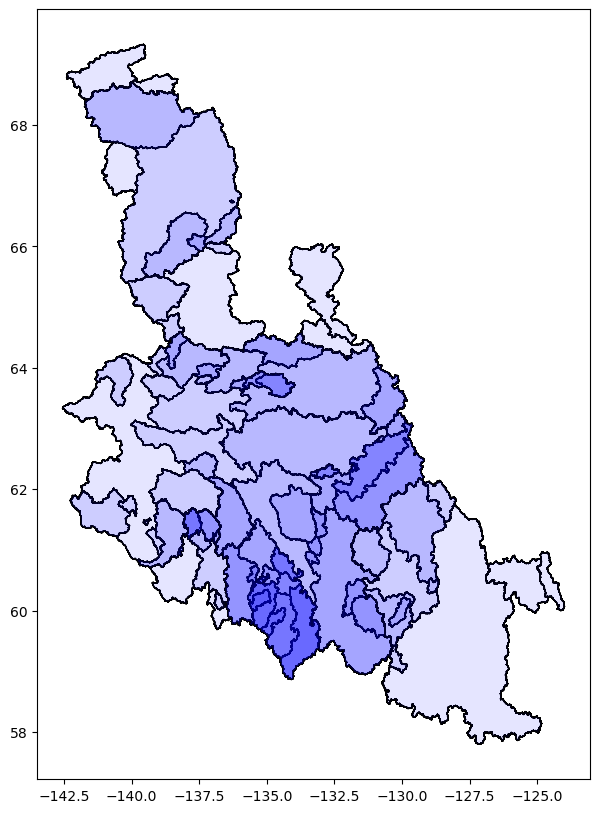

In [ ]:


# Load database configuration from .Renviron
sys.path.append(str(Path.home() / "Documents" / "github" / "YGwater" / "dev"))
from pyquacache.defs.config import db_url_dev as db_url



# Create a database engine
engine = create_engine(db_url)

basins = {}
res = []
polys = []
# Test the connection by listing tables
with engine.connect() as connection:
    geom_results = connection.execute(text("SELECT ST_AsText(geom) as geom FROM vectors WHERE layer_name = 'Drainage basins';"))
    results = connection.execute(text("SELECT * FROM vectors WHERE layer_name = 'Drainage basins';"))
    
    for geom_row, row in zip(geom_results, results):
        polys.append(wkt.loads(geom_row)[0])
        res.append(row)
basins = gpd.GeoDataFrame(res, geometry=polys, crs="epsg:4269")
basins.set_index("feature_name", inplace=True)

ax = basins.plot(edgecolor="black", facecolor="none", figsize=(10, 10))
basins.plot(ax=ax, marker='o', color='blue', alpha=0.1, edgecolor="black", markersize=25)

Here, we define a function to sample the continuous gridded results via basin boundaries. The results for elevation, from the OK earlier, are plotted for basin boundaries.

In [ ]:
# Create a database engine
engine = create_engine(db_url)

gdf = {}
res = []
polys = []


stations = basins.index.to_list()

def list_to_sql_string(lst):
    return ", ".join([f"'{item}'" for item in lst])


# Combine the queries into a single SQL statement using JOINs
query = f"""
SELECT 
    t.timeseries_id, t.parameter_id, t.location, p.param_name
FROM 
    timeseries t
JOIN 
    parameters p ON t.parameter_id = p.parameter_id
WHERE 
    t.location IN ({list_to_sql_string(stations)});
"""

with engine.connect() as connection:
    res = connection.execute(text(query))

# Fetch the results into a DataFrame
timeseries_df = pd.DataFrame(data=res.fetchall(), columns=res.keys())
timeseries_df.set_index(timeseries_df.columns[0], inplace=True)
parameter_ids = timeseries_df["parameter_id"]
timeseries_ids = timeseries_df.index.tolist()

with engine.connect() as connection:
    res = connection.execute(text(f"SELECT date, timeseries_id, value FROM measurements_calculated_daily WHERE timeseries_id IN ({list_to_sql_string(timeseries_ids)});"))


df = pd.DataFrame(data=res.fetchall(), columns=res.keys())
df.set_index(df.columns[0], inplace=True)
df.index = pd.to_datetime(df.index)
df["value"] = df["value"].astype(float)

# Group the DataFrame by 'timeseries_id' and pivot to create columns for each timeseries_id
df_grouped = df.pivot_table(index=df.index, columns='timeseries_id', values='value')

# Rename the columns to include 'timeseries_' prefix for clarity
#df_grouped.columns = [f"timeseries_{col}" for col in df_grouped.columns]


# Set the columns as a MultiIndex with 'param_name' and 'location'
df_grouped.columns = pd.MultiIndex.from_tuples(
    [(timeseries_df.loc[col, 'param_name'], timeseries_df.loc[col, 'location']) for col in df_grouped.columns],
    names=['param_name', 'location']
)
# Reset the index to make the DataFrame easier to work with



In [ ]:
df_grouped

param_name       flow water level                          flow water level  \
location      08AA003     08AA003   08AA005   08AA007   08AA008     08AA008   
date                                                                          
1902-05-01        NaN         NaN       NaN       NaN       NaN         NaN   
1902-05-02        NaN         NaN       NaN       NaN       NaN         NaN   
1902-05-03        NaN         NaN       NaN       NaN       NaN         NaN   
1902-05-04        NaN         NaN       NaN       NaN       NaN         NaN   
1902-05-05        NaN         NaN       NaN       NaN       NaN         NaN   
...               ...         ...       ...       ...       ...         ...   
2025-07-13  72.992361    3.302028  2.296361  2.390340  7.062743    2.390340   
2025-07-14  71.167708    3.289719  2.300910  2.391587  7.095278    2.391587   
2025-07-15  69.880208    3.280941  2.306861  2.396104  7.212361    2.396104   
2025-07-16  71.058333    3.288997  2.322962  2.408788  7.543229    2.408788   
2025-07-17  70.860544    3.287579  2.323242  2.411248  7.606846    2.411248   

param_name      flow water level      flow water level  ...  \
location     08AA009     08AA009   08AA010     08AA010  ...   
date                                                    ...   
1902-05-01       NaN         NaN       NaN         NaN  ...   
1902-05-02       NaN         NaN       NaN         NaN  ...   
1902-05-03       NaN         NaN       NaN         NaN  ...   
1902-05-04       NaN         NaN       NaN         NaN  ...   
1902-05-05       NaN         NaN       NaN         NaN  ...   
...              ...         ...       ...         ...  ...   
2025-07-13  0.527382    0.650128  3.104722    3.060486  ...   
2025-07-14  0.539330    0.653778  3.103125    3.060451  ...   
2025-07-15  0.568403    0.662274  3.209931    3.063497  ...   
2025-07-16  0.614257    0.675597  3.281389    3.065556  ...   
2025-07-17  0.633607    0.680987  3.290200    3.065767  ...   

param_name temperature, water                                                  \
location              10AA005 10AA006 10AB001 10MA002 10MB003 10MB004 10MD001   
date                                                                            
1902-05-01                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1902-05-02                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1902-05-03                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1902-05-04                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1902-05-05                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...                       ...     ...     ...     ...     ...     ...     ...   
2025-07-13                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2025-07-14                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2025-07-15                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2025-07-16                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2025-07-17                NaN     NaN     NaN     NaN     NaN     NaN     NaN   

param_name            flow          
location   10MD002 YEC-MRM YEC-MRW  
date                                
1902-05-01     NaN     NaN     NaN  
1902-05-02     NaN     NaN     NaN  
1902-05-03     NaN     NaN     NaN  
1902-05-04     NaN     NaN     NaN  
1902-05-05     NaN     NaN     NaN  
...            ...     ...     ...  
2025-07-13     NaN     NaN     NaN  
2025-07-14     NaN     NaN     NaN  
2025-07-15     NaN     NaN     NaN  
2025-07-16     NaN     NaN     NaN  
2025-07-17     NaN     NaN     NaN  

[39940 rows x 254 columns]

C:\Users\esniede\AppData\Local\Temp\ipykernel_10036\2249936085.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  basins = basins.assign(area=basins.geometry.area).sort_values(by="area", ascending=False)


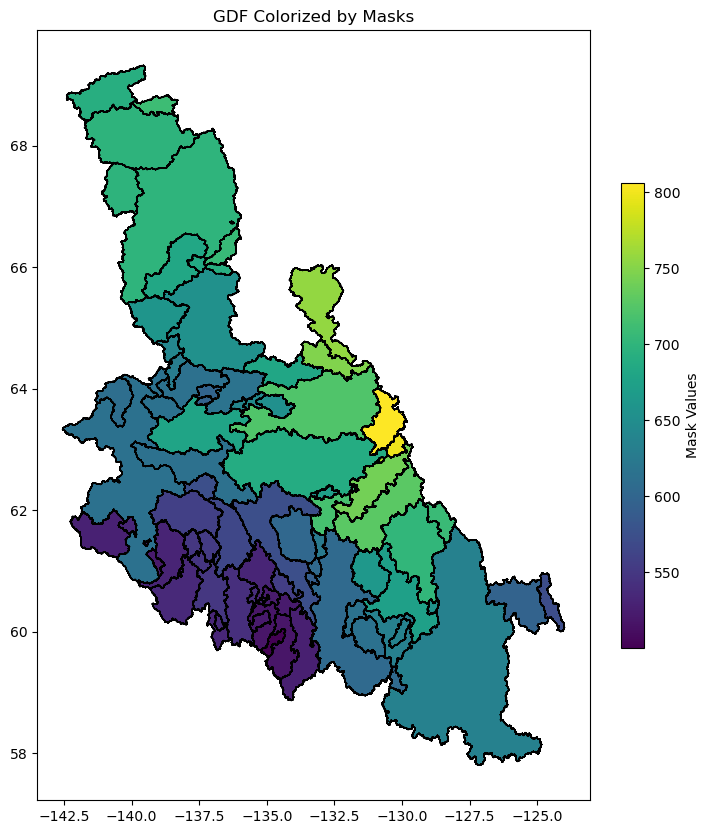

In [ ]:
import matplotlib as mpl
from rasterio.transform import from_bounds
from pydroinformatics.pydroinformatics.spatialutils import point_to_grid, aggregate_gridded_results_by_poly

grid_x, grid_y, grid_z = point_to_grid(lons, lats, values)
masks = aggregate_gridded_results_by_poly(grid_x, grid_y, grid_z, gdf=basins)

# Plot the GeoDataFrame with color based on the masks
fig, ax = plt.subplots(figsize=(10, 10))
basins = basins.assign(area=basins.geometry.area).sort_values(by="area", ascending=False)
# Normalize the mask values for the color map
norm = mpl.colors.Normalize(vmin=min(masks.values()), vmax=max(masks.values()))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Plot the GeoDataFrame with color based on the masks
basins.plot(ax=ax, color=[plt.cm.viridis(norm(masks[idx])) for idx in basins.index], edgecolor="black")

# Add a colorbar
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label("Mask Values")

plt.title("GDF Colorized by Masks")
plt.show()


The cell below grabs two variables, drought code and date (as day of year) for freeze and snowfree dataframes. Results are agrigated into a single multi-indexed [year,(basin,param)] dataframe.

In [ ]:

years = np.unique(np.concatenate([freeze["freeze_date"].dt.year, snowfree["snowfree_date"].dt.year]))
years = years[~np.isnan(years)]

df = pd.DataFrame(index=years, columns=pd.MultiIndex.from_product([basins.index, ["freeze_doy", "freeze_dc", "snowfree_doy", "snowfree_dc"]]))

datasets = {"freeze": freeze, "snowfree": snowfree}
params = ["dc", "doy"]

# for freeze and thaw df
for key in datasets:
    ds = datasets[key]

    # for each year
    for year in years:

        # for each param (DAY OF YEAR [DOY] and DROUGHT DODE [DC])
        for param in params:
            
            # subset  correct date and non-null
            idx = (ds[f"{key}_date"].dt.year == year) & ds[f"{key}_dc"].notnull()
            

            # get the correct param
            if param == "dc":
                values = ds.loc[idx, f"{key}_dc"].astype(float).values
            elif param == "doy":
                values = ds.loc[idx, f"{key}_date"].dt.dayofyear.astype(float).values
            else:
                raise ValueError("Invalid parameter. Must be either 'dc' or 'doy'.")
            

            # if valid data, get basin avgs
            if (values.var() != 0) & (len(values) != 1) & (len(values) != 0):
                lats = ds.loc[idx, "geometry"].y.values
                lons = ds.loc[idx, "geometry"].x.values

                grid_x, grid_y, grid_z = point_to_grid(lons, lats, values)
                basin_avgs = aggregate_gridded_results_by_poly(grid_x, grid_y, grid_z, gdf=basins)
                
                for basin in basins.index:
                    df.loc[year, (basin, f"{key}_{param}")] = basin_avgs[basin]
            
            # 
            elif (len(values) == 1) | (values.var() == 0):
                for basin in basins.index:
                    df.loc[year, (basin, f"{key}_{param}")] = values[0]

            else: 
            # if no values, nan
                for basin in basins.index:
                 df.loc[year, (basin, f"{key}_{param}")] = np.nan


C:\Users\esniede\AppData\Local\Temp\ipykernel_10036\131476766.py:33: RuntimeWarning: Degrees of freedom <= 0 for slice
  if (values.var() != 0) & (len(values) != 1) & (len(values) != 0):
c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\esniede\AppData\Local\Temp\ipykernel_10036\131476766.py:44: RuntimeWarning: Degrees of freedom <= 0 for slice
  elif (len(values) == 1) | (values.var() == 0):
C:\Users\esniede\AppData\Local\Temp\ipykernel_10036\131476766.py:33: RuntimeWarning: Degrees of freedom <= 0 for slice
  if (values.var() != 0) & (len(values) != 1) & (len(values) != 0):
c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWAT

In [ ]:
df

feature_name     09EB001                                          09CD001  \
              freeze_doy   freeze_dc snowfree_doy snowfree_dc  freeze_doy   
2002.0         286.41225  437.305656          NaN         NaN  284.793995   
2003.0        297.069086  528.896552   125.950919  184.751366  296.390086   
2004.0        301.030122  488.903226   128.517241  122.896552  300.385532   
2005.0        278.022348  437.170124   125.833333  135.859852  275.566001   
2006.0        292.484848       477.0   132.599608  118.787879  292.484848   
2007.0        277.250333  459.927393   132.916667  129.166667   277.60933   
2008.0        287.514858  337.297197   128.305556  124.864653  287.584719   
2009.0        295.268848  422.933521   135.041584   77.650491   294.22505   
2010.0        292.536775  413.982868   123.455977  164.320105  289.945318   
2011.0        294.512821  368.102564   135.924138   67.820513  294.512821   
2012.0        287.176061  413.224002   136.362804   30.068332  287.351654   
2013.0               NaN         NaN   145.734237   43.615558         NaN   
2014.0        289.755794  340.733121   127.758497  112.799746  289.477119   
2015.0        294.942833  356.833333   125.810906       108.5  295.339958   
2016.0             281.0   419.59451   111.489858  116.643023       281.0   
2017.0        283.783183  427.789174   127.789474  146.429888  283.585622   
2018.0        297.445577      433.75   130.447368   135.22309  297.323782   
2019.0             276.0  589.542857   106.369197  221.948718       276.0   
2020.0            289.25       383.5    128.72973  116.918919      289.25   
2021.0        296.398734  365.953048   137.205128   37.923077  296.506117   
2022.0        290.312771  322.900385   140.773954   43.810811  288.485628   
2023.0        286.817081  424.666667   137.528369   71.841188  285.828674   
2024.0        287.528809  427.453674   131.287722  166.823529  286.847824   

feature_name                                          10BE001              \
               freeze_dc snowfree_doy snowfree_dc  freeze_doy   freeze_dc   
2002.0        436.417831          NaN         NaN  279.552555  414.755716   
2003.0        528.896552    126.44289  181.580093  293.992831  528.896552   
2004.0        488.903226   128.517241  122.896552  298.001729  488.903226   
2005.0        432.787057   125.833333  122.635734  275.017323  415.483794   
2006.0             477.0   133.587516  118.787879  292.484848       477.0   
2007.0         465.79043   132.916667  129.166667  285.686202  376.701648   
2008.0        339.718963   128.305556  115.728983  290.360218  341.647857   
2009.0        414.133885   132.392006   60.997378  293.389099  322.790594   
2010.0        418.931859   124.558682  152.781089  284.760557  372.955716   
2011.0        368.102564   135.641354   67.820513  294.512821  368.102564   
2012.0        413.986137   136.709716   30.934496  286.657055   449.79984   
2013.0               NaN   145.591509   38.224529         NaN         NaN   
2014.0        336.599835   130.033903  106.248501  288.949933  312.262766   
2015.0        356.833333    126.99884       108.5  294.376943  356.833333   
2016.0        402.684836   112.709889  110.347606       281.0  348.611249   
2017.0        416.859793   127.789474  136.511045  285.250179   431.49956   
2018.0            433.75   130.447368  101.821774  294.100682      433.75   
2019.0        589.542857   106.979869  221.948718       276.0  589.542857   
2020.0             383.5    128.72973  116.918919      289.25       383.5   
2021.0        365.101673   137.205128   37.923077  290.813116  361.230204   
2022.0        346.045449   141.587096   43.810811  287.697072  400.354034   
2023.0        424.666667   137.352284   79.003905   287.49811  424.666667   
2024.0        433.934257   132.397599  166.823529   287.66296  467.609142   

feature_name  ...      29BA005                 09FB003              \
              ... snowfree_doy snowfree_dc  freeze_doy   freeze_dc   
2002.0  

Next, we read theannual peak flow/stage and SWE results for select monitoring locaitons

C:\Users\esniede\AppData\Local\Temp\ipykernel_10036\2780635057.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


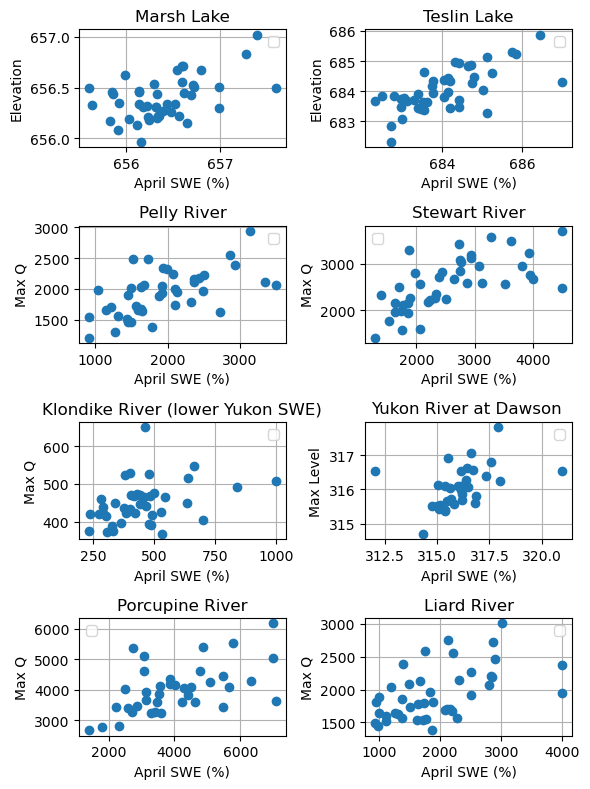

In [ ]:
from scipy.stats import linregress

annual_hydro = pd.read_excel(".data/annual_peaks.xlsx", header=[0, 1], index_col=0)
annual_hydro.index = annual_hydro.index.astype(int)


# last 4 station matches are a bit uncertain (except yukon @ dawson)..
rename_locations = {"Marsh Lake": "09AB004", "Teslin Lake": "09AE002", "Pelly River": "09BC001", "Stewart River": "09DD003", "Klondike River (lower Yukon SWE)": "09EA003", "Yukon River at Dawson ": "09EB001","Porcupine River": "09FD002", "Liard River": "10AA001"}
for name, code in rename_locations.items():
    annual_hydro.rename(columns={name: code}, level=0, inplace=True)

rename_locations_inv = {v: k for k, v in rename_locations.items()}


# Plot time series for all columns containing "Max Q" or "elevation"
cols = [col for col in annual_hydro.columns if ("Max Q" in col) or ("Elevation" in col) or ("Max Level" in col)]

nrows=4
fig, axs = plt.subplots(nrows=nrows, ncols=int(len(cols)/nrows), figsize=(6, 8), sharex=False)
calc_nse = lambda x, y: 1 - (np.sum((x - y) ** 2) / np.sum((y - np.mean(y)) ** 2))
scores = []

for col in cols:
    ax = axs.flatten()[list(cols).index(col)]

    y = annual_hydro.loc[:,col].values
    x = annual_hydro.loc[:,(col[0], "April SWE%")].values

    # Remove NaNs from x and y for regression
    mask = ~np.isnan(x) & ~np.isnan(y) & (y != 0)
    x = x[mask]
    y = y[mask]
    # Calculate the linear regression

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    y_linear = slope * x + intercept

    # Calculate NSE
    nse = calc_nse(y, y_linear)
    scores.append(nse)
    # Plot the trendline
    y_linear = slope * x + intercept


    ax.plot(y, y_linear,'o')

    #ax.plot([x.min(), x.max()], [y.min(), y.max()], color='black', linestyle='--', label=f'Trendline\n$r^2$={r_value**2:.2f}\nNSE={nse:.2f}')

    # Add legend
    ax.legend()
    ax.set_xlabel("April SWE (%)")
    ax.set_ylabel(col[1])
    ax.set_title(f"{rename_locations_inv[col[0]]}")
    ax.grid(True)



fig.tight_layout()



Finally, we merge both dataframes (drought code data and anual hydro data) into a single dataframe. We collapse the station index, in favour of one-hot-encoded station informaiton. This allows us to use the data from all stations for model training, while providing the model with necessary information to distinquish between basins. Currently, stage and discharge are merged into a single column, then normalized. Ultimately, both stage and discharge should be used as independant variables and normalization should be applied on a staiton basis (e.g., prior to collapsing/stacking). TODO.

c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


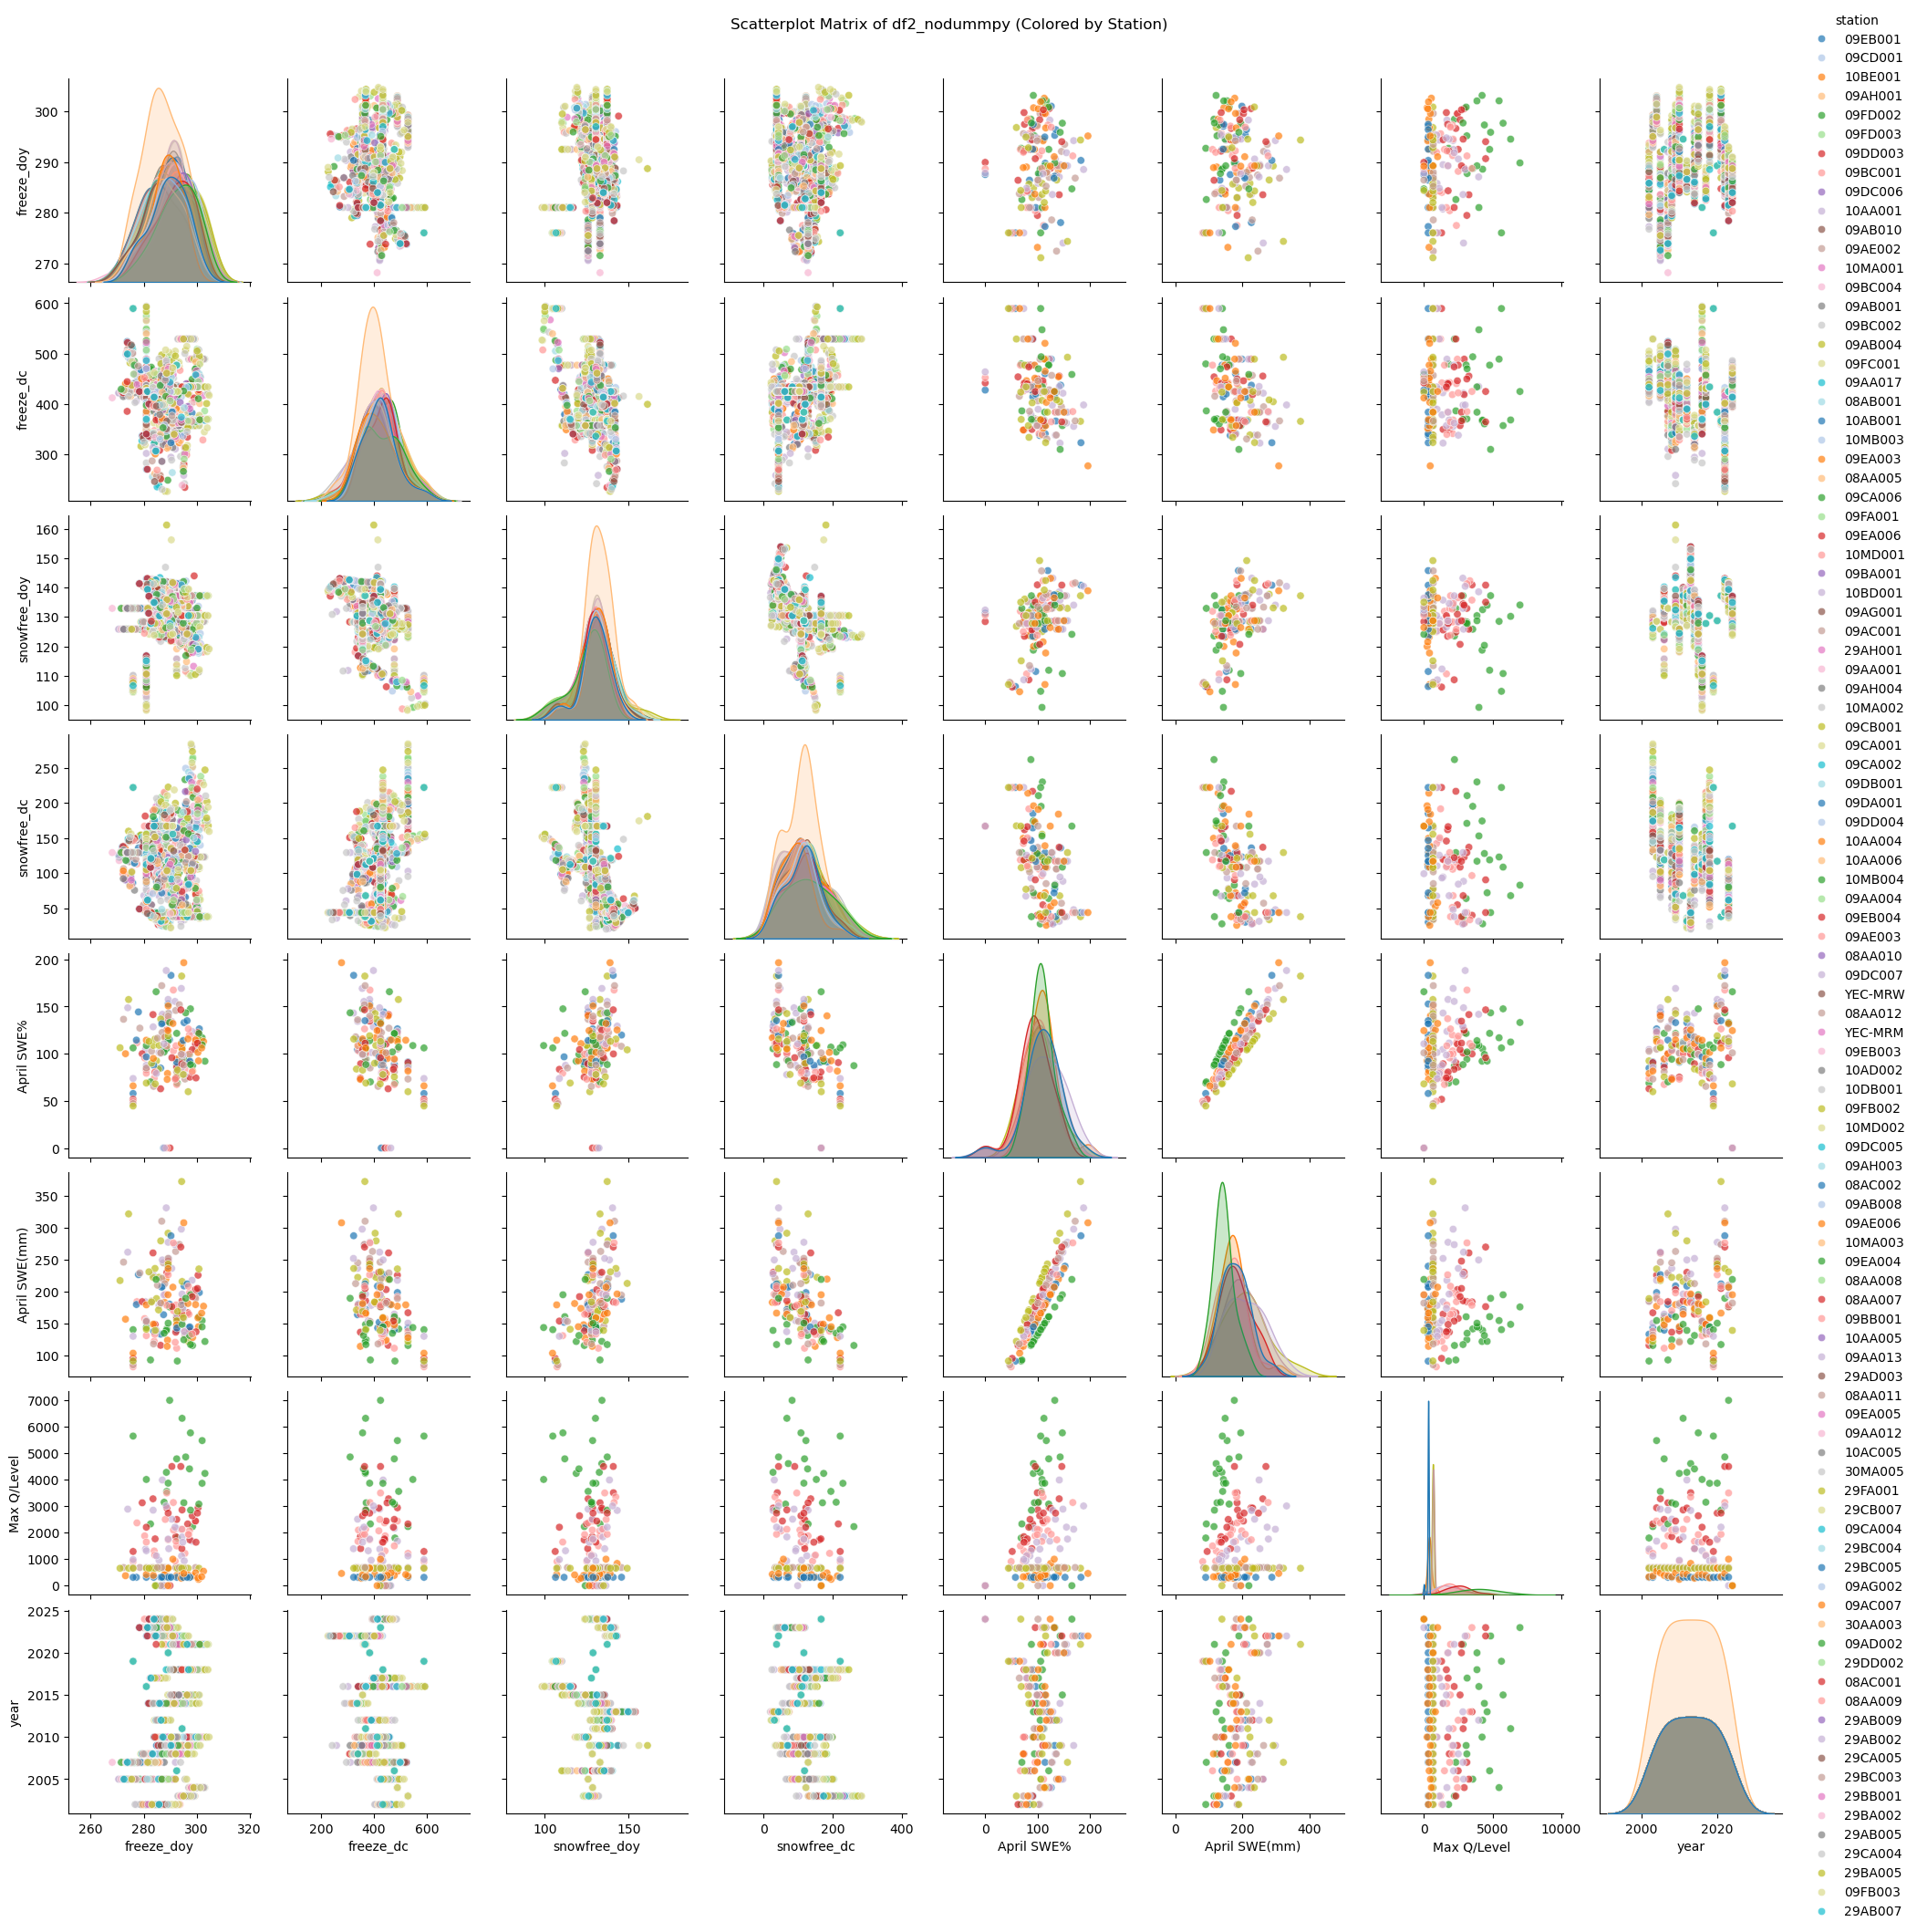

In [ ]:
# Ensure both dataframes have the same index type
df.index = df.index.astype(int)
annual_hydro.index = annual_hydro.index.astype(int)

# Merge the dataframes on their indices
merged_df = pd.merge(df, annual_hydro, left_index=True, right_index=True, how='inner')

# Convert object columns to float where possible
for col in merged_df.columns:
    if merged_df[col].dtype == 'object':
        try:
            merged_df[col] = merged_df[col].astype(float)
        except ValueError:
            pass

data_baseline = merged_df.stack(level=0, future_stack=True)
data_baseline = data_baseline.reset_index(level=1).rename(columns={"level_1": "station"})
data_baseline = pd.get_dummies(data_baseline, columns=["station"], drop_first=True)

# merge these into a single column
data_baseline["Max Q/Level"] = data_baseline[["Max Q", "Max Level", "Elevation"]].apply(lambda x: x.dropna().values[0] if not x.dropna().empty else np.nan, axis=1)
data_baseline.drop(columns=["Max Q", "Max Level", "Elevation"], inplace=True)

station_cols = [col for col in data_baseline.columns if col.startswith("station_")]
cols_to_drop = [col for col in station_cols if data_baseline[col].sum() == 0]
data_baseline = data_baseline.drop(columns=cols_to_drop)
data_baseline

data_n1h = data_baseline.copy()
station_cols = [col for col in data_n1h.columns if col.startswith("station_")]
data_n1h["station"] = data_n1h[station_cols].idxmax(axis=1).str.replace("station_", "")
data_n1h.drop(columns=station_cols, inplace=True)
# Reindex transposed_df2 to ensure a unique integer index
data_n1h["year"] = data_n1h.index
data_n1h.reset_index(drop=True, inplace=True)
# Colour by station column
import seaborn as sns
sns.pairplot(data_n1h, hue="station", diag_kind="kde", palette="tab20", plot_kws={"alpha": 0.7})
plt.suptitle("Scatterplot Matrix of df2_nodummpy (Colored by Station)", y=1.02)
plt.show()

# after plotting, drop the station column
#data_n1h = data_n1h.drop(columns=["station"])



Lastly, we train two models. A multi-variate linear regression model and a random forest model. Peak annual values, and freeze-up data are used to calculate snowfree variables.

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score



def train_model_suite(X, y):
    ret = {}


# Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)


    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    # Initialize the scaler
    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both train and test sets
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Apply z-normalization to the target variable (y) as well
    y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()


    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred_linear = model.predict(X_test)

    # Initialize and train the random forest model
    model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=5)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_rf = model.predict(X_test)

    # Initialize and train the neural network model
    # Define hyperparameter grid for MLPRegressor
    # Use the best hyperparameters found in previous grid search
    # Hyperparameter grid for MLPRegressor (for hyperparameter optimization)
    param_grid = {
        'hidden_layer_sizes': [(8,), (16,), (32,), (64,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'],
        'max_iter': [5000],
        'random_state': [42],
        'alpha': [0.0001, 0.001, 0.01],
    }

    mlp = MLPRegressor()
    grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    nn_model = grid_search.best_estimator_
    nn_model.fit(X_train, y_train)
    print("Best NN params:", grid_search.best_params_)

    # Make predictions on the test set
    y_pred_nn = nn_model.predict(X_test)
    y_pred_linear_train = model.predict(X_train)
    y_pred_rf_train = model.predict(X_train)
    y_pred_nn_train = nn_model.predict(X_train)

    # Inverse transform predictions to original scale as normal arrays
    y_pred_linear = scaler.inverse_transform(np.array(y_pred_linear).reshape(-1, 1)).flatten()
    y_pred_rf = scaler.inverse_transform(np.array(y_pred_rf).reshape(-1, 1)).flatten()
    y_pred_nn = scaler.inverse_transform(np.array(y_pred_nn).reshape(-1, 1)).flatten()
    y_pred_linear_train = scaler.inverse_transform(np.array(y_pred_linear_train).reshape(-1, 1)).flatten()
    y_pred_rf_train = scaler.inverse_transform(np.array(y_pred_rf_train).reshape(-1, 1)).flatten()
    y_pred_nn_train = scaler.inverse_transform(np.array(y_pred_nn_train).reshape(-1, 1)).flatten()

    y_train = scaler.inverse_transform(np.array(y_train).reshape(-1, 1)).flatten()
    y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).flatten()

    for key in ["y_hat", "nse", "r2"]:
        ret[key] = {}

    for key in ["linear", "rf", "nn"]:
        ret["y_hat"][key] = {}
        ret["nse"][key] = {}
        ret["r2"][key] = {}
        
    for key in ["X", "y"]:
        ret[key] = {}
    
    ret["y_hat"]["linear"]["test"] = y_pred_linear
    ret["y_hat"]["rf"]["test"] = y_pred_rf
    ret["y_hat"]["nn"]["test"] = y_pred_nn
    ret["y_hat"]["linear"]["train"] = y_pred_linear_train
    ret["y_hat"]["rf"]["train"] = y_pred_rf_train
    ret["y_hat"]["nn"]["train"] = y_pred_nn_train

    ret["X"]["train"] = X_train
    ret["X"]["test"] = X_test
    ret["y"]["train"] = y_train
    ret["y"]["test"] = y_test

    ret["nse"]["linear"]["test"] = calc_nse(y_test, y_pred_linear)
    ret["nse"]["rf"]["test"] = calc_nse(y_test, y_pred_rf)
    ret["nse"]["nn"]["test"] = calc_nse(y_test, y_pred_nn)

    ret["r2"]["linear"]["test"] = r2_score(y_test, y_pred_linear)
    ret["r2"]["rf"]["test"] = r2_score(y_test, y_pred_rf)
    ret["r2"]["nn"]["test"] = r2_score(y_test, y_pred_nn)
    
    return ret


df2_cleaned = data_n1h.drop(columns="station", inplace=False).dropna()
X = df2_cleaned.drop(columns=["snowfree_dc", "snowfree_doy","Max Q/Level"])
#X = df2_cleaned[["April SWE%"]]
y = df2_cleaned["Max Q/Level"]
results_n1h = train_model_suite(X, y)

df2_cleaned = data_baseline.dropna()
X = df2_cleaned.drop(columns=["snowfree_dc", "snowfree_doy","Max Q/Level"])
#X = df2_cleaned[["April SWE%"]]
y = df2_cleaned["Max Q/Level"]
results_baseline = train_model_suite(X, y)

Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}
Best NN params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


2003     91.280892
2003     87.358062
2003     90.562042
2003     83.537398
2003     85.429448
           ...    
2023    132.077881
2024    165.783497
2024    100.959672
2024     68.009359
2024    124.481328
Name: April SWE%, Length: 158, dtype: float64

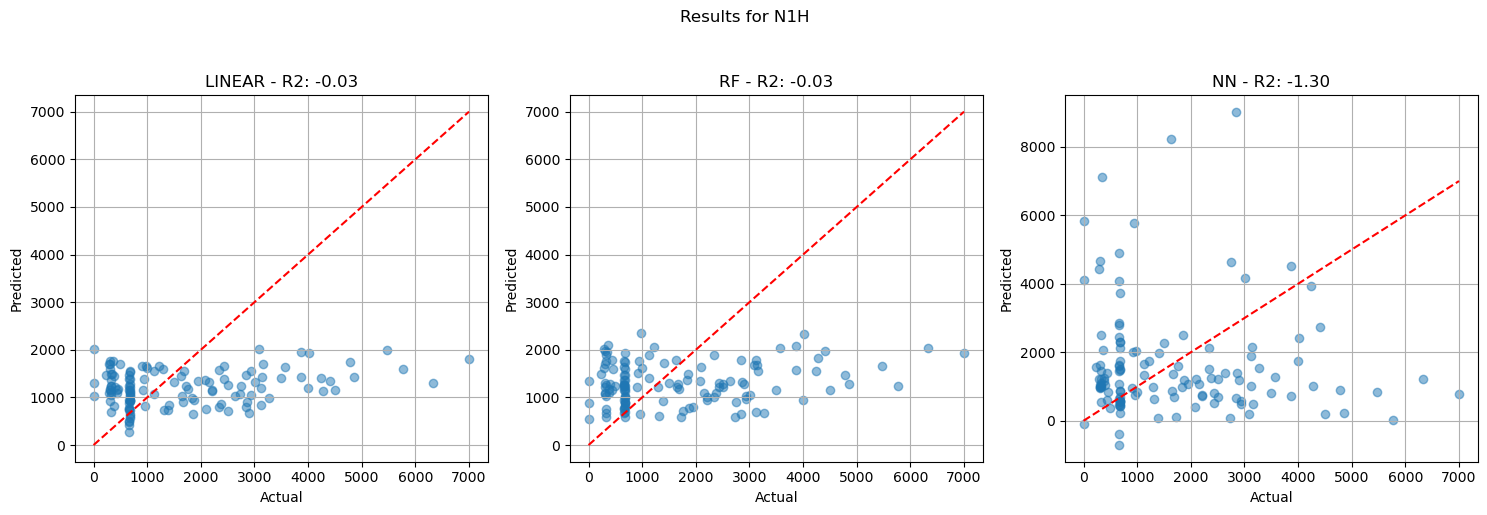

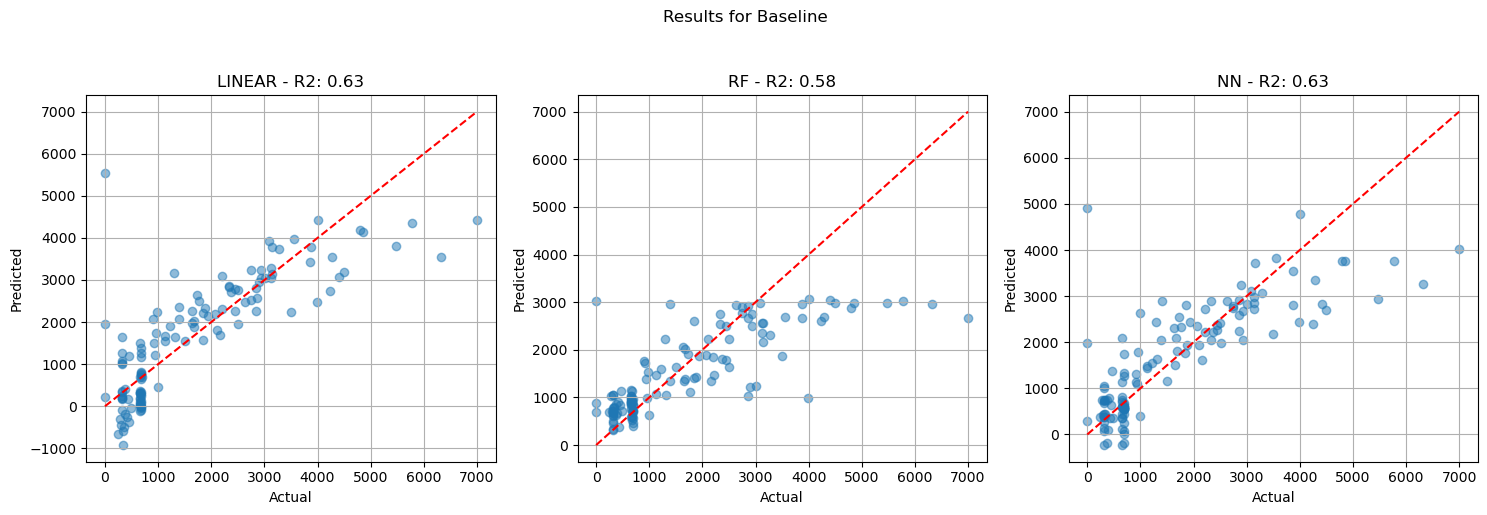

In [ ]:
def plot_results_scatter(res, div="test", title="Results"):
    """
    Plot scatter plots of predicted vs actual values for each model in the results dictionary.
    
    Parameters:
    res (dict): Dictionary containing model results.
    div (str): Division of data to plot ('train' or 'test').
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, model in enumerate(res["y_hat"].keys()):
        ax = axs[i]
        y_true = res["y"][div]
        y_pred = res["y_hat"][model][div]
        ax.scatter(y_true, y_pred, alpha=0.5)
        ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
        ax.set_title(f"{model.upper()} - R2: {res['r2'][model][div]:.2f}")
        ax.grid(True)
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_results_scatter(results_n1h, div="test", title="Results for N1H")
plot_results_scatter(results_baseline, div="test", title="Results for Baseline")

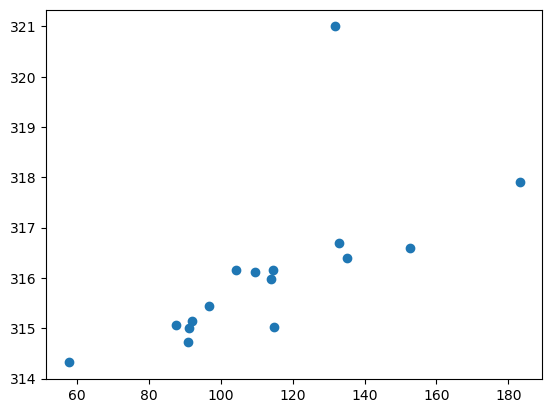

In [ ]:
plt.plot(X,y,'o')

c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


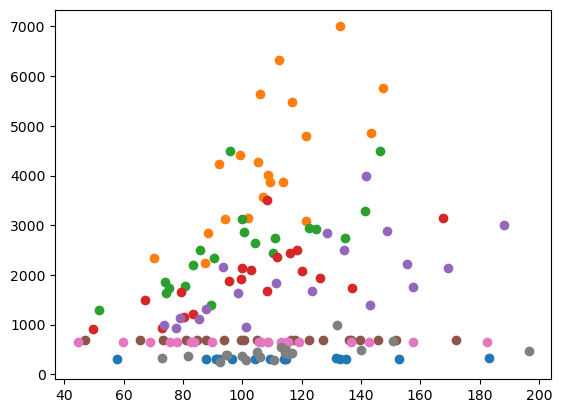

In [ ]:

for station in stations:
    station_data = data_n1h[data_n1h["station"] == station]
    station_data = station_data.drop(columns=["station"], inplace=False)
    df2_cleaned = station_data.dropna()
    X = df2_cleaned.drop(columns=["snowfree_dc", "snowfree_doy","Max Q/Level"])
    X = df2_cleaned[["April SWE%"]]
    X
    y = df2_cleaned["Max Q/Level"]

    idx = y == 0
    X = X[~idx]
    y = y[~idx]
    
    if len(X) > 0 and len(y) > 0:
        results_n1h_station = train_model_suite(X, y)
        #plot_results_scatter(results_n1h_station, div="test", title=f"Results for {station} - N1H")
        
        plt.plot(X,y,'o')




In [ ]:

print(f"NSE value for Neural Net: {nse_nn}")
print(f"NSE value for Linear Regression: {nse_linear}")
print(f"NSE value for Random Forest: {nse_rf}")

# Plot the 1:1 graph
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, color='blue', label='Linear Regression')
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest')
plt.scatter(y_test, y_pred_nn, color='purple', label='Neural Net', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='1:1 Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('1:1 Graph of Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()X_train

array([[-1.57864614,  2.33263142, -2.19875079, ...,  0.        ,
         0.        , -0.41429637],
       [ 0.95451237, -0.99078088, -0.20713903, ...,  0.        ,
         0.        ,  0.75351956],
       [ 1.35664998,  0.10581422, -1.14002725, ...,  0.        ,
         0.        ,  0.4307591 ],
       ...,
       [ 2.06234987,  0.8222153 ,  0.28813416, ...,  0.        ,
         0.        , -0.52541876],
       [-0.89448283, -0.21798129, -0.32779806, ...,  0.        ,
         0.        , -0.71064927],
       [-0.43991651,  0.0861676 , -0.93521781, ...,  0.        ,
         0.        ,  0.46061444]], shape=(31, 104))